In [4]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import os
from PIL import Image
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt


In [5]:
class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None, num_classes=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = os.listdir(root_dir)
        self.num_classes = num_classes

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.images[idx])
        image = Image.open(img_name)
        lbl = self.images[idx].split('.')[0][-1]  # Assuming the label is before the first dot in the filename
        if (lbl=='L'):
            label = 0
        elif lbl=='R':
            label = 1
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Modify the root directory accordingly
train_dataset = CustomImageDataset(root_dir="Fingers\\train", transform=ToTensor(), num_classes=2)
test_dataset = CustomImageDataset(root_dir="Fingers\\test", transform=ToTensor(), num_classes=2)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [6]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

class NeuralNetwork1(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(p=0.1)
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(128*128, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 6)
        )
        self.dropout = nn.Dropout()

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        output = self.dropout(logits)
        return output

class NeuralNetwork2(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(p=0.1)
        self.linear_relu_stack1 = nn.Sequential(
            nn.Linear(128*128, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 1)
        )
        self.linear_relu_stack2 = nn.Sequential(
            nn.Linear(128*128, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 1)
        )
        self.dropout = nn.Dropout()

    def forward(self, x):
        x = self.flatten(x)
        logits1 = self.linear_relu_stack1(x)
        output1 = self.dropout(logits1)
        logits2 = self.linear_relu_stack2(x)
        output2 = self.dropout(logits2, )
        output = torch.cat((output1, output2), dim=1)
        return output

    

model1 = NeuralNetwork1().to(device)
print(model1)
model2 = NeuralNetwork2().to(device)
print(model2)

Using cpu device
NeuralNetwork1(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dropout): Dropout(p=0.5, inplace=False)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=16384, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=6, bias=True)
  )
)
NeuralNetwork2(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dropout): Dropout(p=0.5, inplace=False)
  (linear_relu_stack1): Sequential(
    (0): Linear(in_features=16384, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=1, bias=True)
  )
  (linear_relu_stack2): Sequential(
    (0): Linear(in_features=16384, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=1, bias=True)
  

In [7]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model1.parameters(), lr=1e-3)
optimizer = torch.optim.SGD(model2.parameters(), lr=1e-3, momentum=0.9)

In [8]:
train_losses = []


In [9]:
def plot_losses(train_losses):
    plt.figure(figsize=(10,5))
    plt.plot(train_losses, label='Training loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Losses')
    plt.legend()
    plt.show()

In [10]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
            train_losses.append(loss)
            


In [11]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    all_preds = []
    all_targets = []
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()  # Check if this line is correct
            _, predicted = torch.max(pred, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(y.cpu().numpy())
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    f1_test = f1_score(all_targets, all_preds, average='macro')
    print(f'F1 Score on test data: {f1_test}')  # Check if this line is correct


Epoch 1
-------------------------------


c:\Users\BARANLAPTOP\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\transforms.py:36: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(pic.tobytes()))


loss: 1.760279  [   64/18000]
loss: 1.758411  [ 6464/18000]
loss: 1.763108  [12864/18000]
Test Error: 
 Accuracy: 47.6%, Avg loss: 1.756456 

F1 Score on test data: 0.22550439650633047
Epoch 2
-------------------------------
loss: 1.754686  [   64/18000]
loss: 1.756276  [ 6464/18000]
loss: 1.758037  [12864/18000]
Test Error: 
 Accuracy: 47.6%, Avg loss: 1.756456 

F1 Score on test data: 0.22550439650633047
Epoch 3
-------------------------------
loss: 1.745419  [   64/18000]
loss: 1.761694  [ 6464/18000]
loss: 1.754158  [12864/18000]
Test Error: 
 Accuracy: 47.6%, Avg loss: 1.756456 

F1 Score on test data: 0.22550439650633047
Epoch 4
-------------------------------
loss: 1.762860  [   64/18000]
loss: 1.759850  [ 6464/18000]
loss: 1.754821  [12864/18000]
Test Error: 
 Accuracy: 47.6%, Avg loss: 1.756456 

F1 Score on test data: 0.22550439650633047
Epoch 5
-------------------------------
loss: 1.753567  [   64/18000]
loss: 1.760655  [ 6464/18000]
loss: 1.763292  [12864/18000]
Test Error

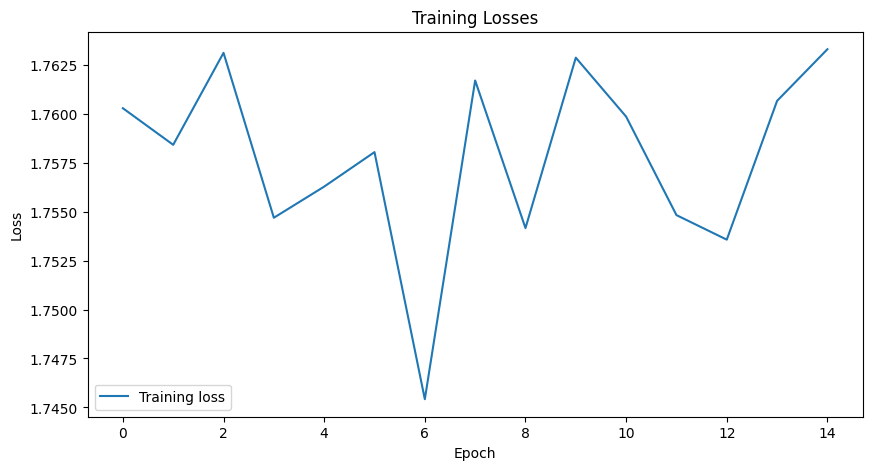

Epoch 1
-------------------------------
loss: 0.694814  [   64/18000]
loss: 0.635560  [ 6464/18000]
loss: 0.578406  [12864/18000]
Test Error: 
 Accuracy: 94.8%, Avg loss: 0.408800 

F1 Score on test data: 0.9480364661740319
Epoch 2
-------------------------------
loss: 0.463515  [   64/18000]
loss: 0.371776  [ 6464/18000]
loss: 0.227315  [12864/18000]
Test Error: 
 Accuracy: 97.1%, Avg loss: 0.178315 

F1 Score on test data: 0.9713888866812412
Epoch 3
-------------------------------
loss: 0.269328  [   64/18000]
loss: 0.243203  [ 6464/18000]
loss: 0.244960  [12864/18000]
Test Error: 
 Accuracy: 98.4%, Avg loss: 0.105281 

F1 Score on test data: 0.9841666654449588
Epoch 4
-------------------------------
loss: 0.152459  [   64/18000]
loss: 0.231266  [ 6464/18000]
loss: 0.234943  [12864/18000]
Test Error: 
 Accuracy: 98.9%, Avg loss: 0.073079 

F1 Score on test data: 0.9888886111041666
Epoch 5
-------------------------------
loss: 0.206794  [   64/18000]
loss: 0.209178  [ 6464/18000]
loss

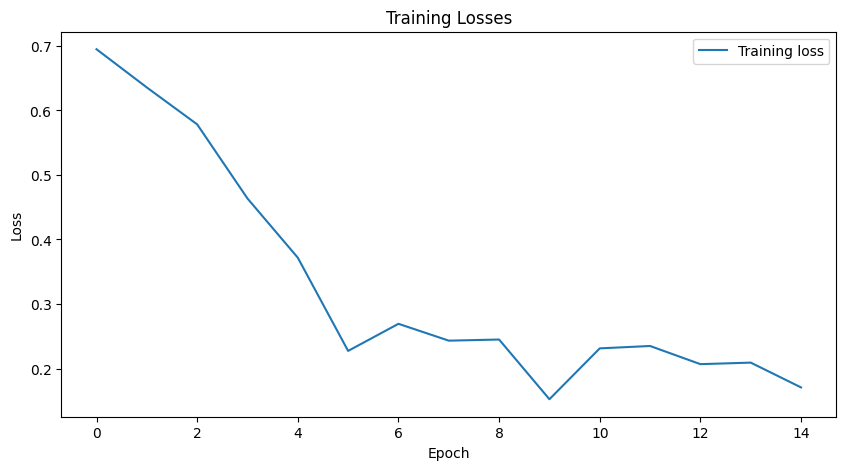

Done!


In [12]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_loader, model1, loss_fn, optimizer)
    test(test_loader, model1, loss_fn)
    
plot_losses(train_losses)

train_losses = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_loader, model2, loss_fn, optimizer)
    test(test_loader, model2, loss_fn)
    
plot_losses(train_losses)
    
print("Done!")

In [13]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

num_params = count_parameters(model1)
print(f"Number of parameters in the neural network 1: {num_params}")

num_params = count_parameters(model2)
print(f"Number of parameters in the neural network 2: {num_params}")

Number of parameters in the neural network 1: 8654854
Number of parameters in the neural network 2: 17304578


In [14]:
torch.save(model1.state_dict(), "model1.pth")
print("Saved PyTorch Model1 State to model1.pth")

torch.save(model2.state_dict(), "model2.pth")
print("Saved PyTorch Model1 State to model2.pth")

Saved PyTorch Model1 State to model1.pth
Saved PyTorch Model1 State to model2.pth


In [15]:
model1 = NeuralNetwork1().to(device)
model1.load_state_dict(torch.load("model.pth"))

model2 = NeuralNetwork2().to(device)
model2.load_state_dict(torch.load("model.pth"))

RuntimeError: Error(s) in loading state_dict for NeuralNetwork1:
	size mismatch for linear_relu_stack.4.weight: copying a param with shape torch.Size([2, 512]) from checkpoint, the shape in current model is torch.Size([6, 512]).
	size mismatch for linear_relu_stack.4.bias: copying a param with shape torch.Size([2]) from checkpoint, the shape in current model is torch.Size([6]).

In [ ]:
# Replace this part
classes = [
    "Left",
    "Right"
]

model1.eval()
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        pred = model1(x)
        _, predicted = torch.max(pred, 1)
        for pred_val, actual_val in zip(predicted, y):
            predicted_class = classes[pred_val.item()]
            actual_class = classes[actual_val.item()]
            print(f'Predicted: "{predicted_class}", Actual: "{actual_class}"')


NameError: name 'test_data' is not defined